<a href="https://colab.research.google.com/github/Satwikram/NLP-Implementations/blob/main/Fine%20Tuning%20Bert%20in%20Native%20tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Connecting to Kaggle

In [1]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading the dataset

In [ ]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

In [3]:
!unzip /content/news-headlines-dataset-for-sarcasm-detection.zip

Archive:  /content/news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


### Importing Dependencies

In [ ]:
!pip install transformers

In [5]:
import numpy as np
import pandas as pd

import tensorflow as tf

### Loading Dataset

In [6]:
dataset = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines = True)

In [7]:
dataset.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


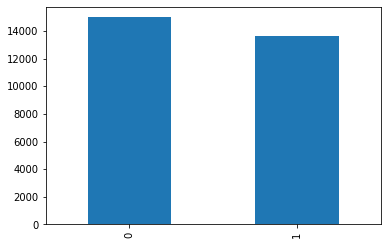

In [11]:
dataset["is_sarcastic"].value_counts().plot(kind = "bar")

### Preparing data for BERT

In [14]:
sequence_length = 512
num_samples = len(dataset)

num_samples, sequence_length

(28619, 512)

### Importing BERT Tokenizer

In [15]:
from transformers import BertTokenizer

### Tokenization

In [16]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
tokens = tokenizer(dataset["headline"].tolist(), max_length = sequence_length, 
                   truncation = True, padding = "max_length", add_special_tokens = True,
                   return_tensors = "np")

In [19]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [22]:
tokens["input_ids"]

array([[  101,  4228, 14045, ...,     0,     0,     0],
       [  101, 17183, 16360, ...,     0,     0,     0],
       [  101,  4521,  2115, ...,     0,     0,     0],
       ...,
       [  101,  1996,  2087, ...,     0,     0,     0],
       [  101,  7733, 15113, ...,     0,     0,     0],
       [  101,  3611, 18856, ...,     0,     0,     0]])

In [21]:
tokens["attention_mask"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])